In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import numpy as np

In [2]:
column_dict = {'09034900': 'BOBTAIL CREEK NEAR JONES PASS, CO.',
                '09035900': 'SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.',
                '09035800': 'DARLING CREEK NEAR LEAL, CO.',
                '09047700': 'KEYSTONE GULCH NEAR DILLON, CO.',
                '09066000': 'BLACK GORE CREEK NEAR MINTURN, CO.',
                '09065500': 'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
                '09066200': 'BOOTH CREEK NEAR MINTURN, CO.',
                '09066300': 'MIDDLE CREEK NEAR MINTURN, CO.',
                '09081600': 'CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.',
                '09107000': 'TAYLOR RIVER AT TAYLOR PARK, CO.',
                '09110000': 'TAYLOR RIVER AT ALMONT, CO.',
                '09112500': 'EAST RIVER AT ALMONT CO.',
                '09115500': 'TOMICHI CREEK AT SARGENTS, CO.',
                '09119000': 'TOMICHI CREEK AT GUNNISON, CO.',
                '09124500': 'LAKE FORK AT GATEVIEW, CO.',
                '09125000': 'CURECANTI CREEK NEAR SAPINERO, CO.',
                '09128500': 'SMITH FORK NEAR CRAWFORD, CO.',
                '09132500': 'NORTH FORK GUNNISON RIVER NEAR SOMERSET, CO.',
                '09146200': 'UNCOMPAHGRE RIVER NEAR RIDGWAY, CO.',
                '09147500': 'UNCOMPAHGRE RIVER AT COLONA, CO.',
                '09165000': 'DOLORES RIVER BELOW RICO, CO.',
                '09168100': 'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
                '09239500': 'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
                '09241000': 'ELK RIVER AT CLARK, CO.',
                '09245000': 'ELKHEAD CREEK NEAR ELKHEAD, CO.',
                '09250000': 'MILK CREEK NEAR THORNBURGH, CO.',
                '09304500': 'WHITE RIVER NEAR MEEKER, CO.',
                '09352900': 'VALLECITO CREEK NEAR BAYFIELD, CO.',
                '09361500': 'ANIMAS RIVER AT DURANGO, CO.'}
sm_cols = list(column_dict.keys())

### Pull in SNTL Data, basins and closest sntl sites

In [3]:
# UCRB Basins
ucrb_hcdn_basins = gpd.read_file('./ucrb_hcdn_co_polygons_final.json')

# Get SNTL data
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)

gdf_sntl = gdf_sntl.to_crs('4326')
nearest_sntl = {}

for i,basin in enumerate(ucrb_hcdn_basins.centroid):
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist_sntl = {r[1]['site_id']: r[1]['geometry'].distance(basin) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')][['site_id','geometry']].iterrows()}
    # get the nearest point index
    idx_sntl = sorted(dist_sntl.items(), key=itemgetter(1))[:2]
    #get the point by index
    nearest_sntl[ucrb_hcdn_basins.iloc[i]['STAID']] = [site[0] for site in idx_sntl]

nearest_sntl_ds = xr.open_dataset('./hcdn_closest_sntl_20220930.nc')
second_sntl_ds = xr.open_dataset('./hcdn_second_closest_sntl_20210930.nc')
# Pull in sntl data
hcdn_sntl_swe_ds = xr.concat([nearest_sntl_ds,second_sntl_ds], dim='Location')


C:\Users\dlhogan\AppData\Local\Temp\ipykernel_21136\1564393012.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for i,basin in enumerate(ucrb_hcdn_basins.centroid):


In [4]:
# Clean SNTL data
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC']>=0))
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC'].diff(dim='Date')<20))

# Open PRISM data

In [5]:
# Download PRISM normals 
outpath = '../../data/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
prism_list = []
for file in files:
       prism_list.append(rioxr.open_rasterio(os.path.join(outpath,file)))
prism_normals_ds = xr.concat(prism_list, dim='band')
prism_normals_ds = prism_normals_ds.rename({'band':'month'})

prism_normals_ds = prism_normals_ds.assign_coords({
        'month': [1,2,3,4,5,6,7,8,9,10,11,12]})


### Create SNOTEL Normals Dataset for One Basin - East River and Taylor River to compare.

In [6]:
sntl_id = '380:CO:SNTL'
east_river = gpd.read_file('../multisite/polygons/east_taylor.json')
east_river = east_river[east_river['name']=='East River']
x1 = gdf_sntl[gdf_sntl['site_id'] == sntl_id].geometry.x.values
y1 = gdf_sntl[gdf_sntl['site_id'] == sntl_id].geometry.y.values
    
tmp_gdf = east_river.to_crs('4326')

basin_prism = prism_normals_ds.rio.clip(tmp_gdf.geometry)

# Get sntl PRISM value

if not tmp_gdf.set_crs(4326).reset_index().contains(gdf_sntl[gdf_sntl['site_id'] == sntl_id].reset_index()).values:
    print('Nearest SNTL is not in basin!')

nearest_sntl_prism_val = prism_normals_ds.sel(x=x1, method='nearest').sel(y=y1, method='nearest').squeeze()


# Create prism multiplier
prism_multiplier = basin_prism/nearest_sntl_prism_val

# Get monthly precip from SNOTEL
single_site = hcdn_sntl_swe_ds.sel(Location=sntl_id)
time_first = single_site.resample(Date='1M').first()['PREC']
time_last = single_site.resample(Date='1M').last()['PREC']
sntl_monthly_precip = (time_last - time_first) * 10 # convert to mm

# Create list for monthly prism datasets
monthly_prism = []
for mo in np.arange(1,13,1):
    tmp_ds = prism_multiplier.sel(month=mo) * sntl_monthly_precip.where(sntl_monthly_precip.Date.dt.month==mo).isel(Location=0)
    tmp_ds.name = 'Monthly Precip [mm]'
    tmp_ds = tmp_ds.where(tmp_ds >= 0).to_dataframe().dropna().to_xarray()
    monthly_prism.append(tmp_ds)
ds = xr.concat(monthly_prism,dim='Date').sortby('Date')
ds = ds.assign_coords({'WY':ds.Date.dt.year.where(ds.Date.dt.month < 10, ds.Date.dt.year + 1)})

In [7]:
dec_fig = ds['Monthly Precip [mm]'].where(ds.Date.dt.month == 12)
dec_fig_norm = (dec_fig-dec_fig.mean(dim='Date'))/dec_fig.std(dim='Date')

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
%matplotlib inline                                                

Text(0.5, 1.0, 'May PRISM Precip Climatology over the East River')

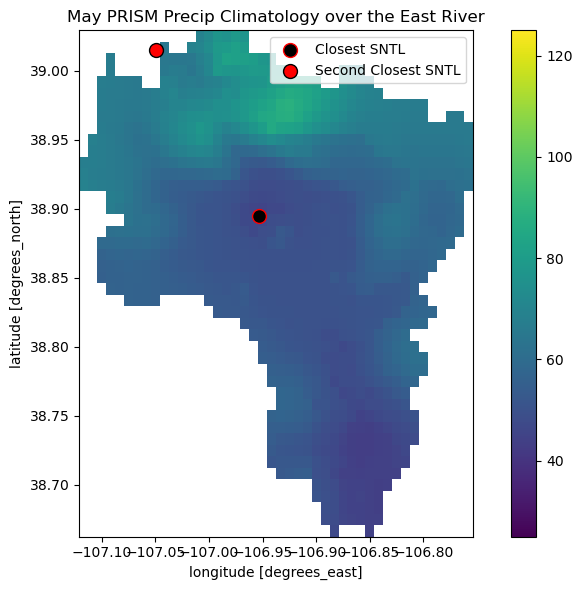

In [9]:
site = 11
tmp_gdf = gpd.GeoDataFrame(ucrb_hcdn_basins.loc[site]).T
basin_prism = basin_prism.where(basin_prism>=0)

# Create a quick example plot of where the nearest SNTL is on the PRISM data
fig, ax = plt.subplots(figsize=(8,6),tight_layout=True)
basin_prism.sel(month=8).plot(ax=ax, vmin=25, vmax=125)
gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['STAID']][0]].plot(ax=ax, markersize=100, label='Closest SNTL', color='k', ec='red');
gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['STAID']][1]].plot(ax=ax, markersize=100, label='Second Closest SNTL', color='red', ec='k');
ax.legend()
ax.set_title('May PRISM Precip Climatology over the East River')


In [10]:
def single_hcdn_basin_prism_precip(site_no):
    """Get the basin prism precip values derived from method used in Raleigh and Lundquist 2012. Grabs nearest SNTL data to build a SNTL weight
    is then applied to the remaining cells within the basin. This value is also compared to the second closest snotels and flags sites where these
    SNOTELs have very different values.     

    Args:
        site_no (string or int): USGS gage site number 

    Returns:
        ds: xarray dataset containing monthly precip derived from SNTL and PRISM normals
    """
    if type(site_no) is str:
        tmp_gdf = ucrb_hcdn_basins[ucrb_hcdn_basins['STAID']==site_no]
        sntl_id = nearest_sntl[site_no][0]
        sntl_id2 = nearest_sntl[site_no][1]
        x1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][0]].geometry.x.values
        y1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][0]].geometry.y.values
        x2 =gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][1]].geometry.x.values
        y2 =gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][1]].geometry.y.values
        
    else:
        tmp_gdf = gpd.GeoDataFrame(ucrb_hcdn_basins.loc[site_no]).T
        sntl_id = nearest_sntl[ucrb_hcdn_basins.loc[site_no]['STAID']][0]
        sntl_id2 = nearest_sntl[ucrb_hcdn_basins.loc[site_no]['STAID']][1]
        x1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id]].geometry.x.values
        y1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id]].geometry.y.values
        x2 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id2]].geometry.x.values
        y2 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id2]].geometry.y.values
        
    tmp_gdf = tmp_gdf.set_crs('4326')
    
    basin_prism = prism_normals_ds.rio.clip(tmp_gdf.geometry)
    basin_prism = basin_prism.where(basin_prism>=0)

    # Get sntl PRISM value

    if not tmp_gdf.set_crs(4326).reset_index().contains(gdf_sntl[gdf_sntl['site_id'] == sntl_id].reset_index()).values:
        print('Nearest SNTL is not in basin!')

    nearest_sntl_prism_val = prism_normals_ds.sel(x=x1, method='nearest').sel(y=y1, method='nearest').squeeze()
    second_sntl_prism_val = prism_normals_ds.sel(x=x2, method='nearest').sel(y=y2, method='nearest').squeeze()
    
    if abs((nearest_sntl_prism_val/second_sntl_prism_val).std()) > 1:
        print('Check SNOTEL site choice, two closest SNTLs are very different')
    
    # Create prism multiplier
    prism_multiplier = basin_prism/nearest_sntl_prism_val

    # Get monthly precip from SNOTEL
    single_site = hcdn_sntl_swe_ds.sel(Location=sntl_id)['PREC']
    if 'Location' in single_site.dims:
        single_site = single_site.isel(Location=0)
    time_first = single_site.resample(Date='1M').first()
    time_last = single_site.resample(Date='1M').last()
    sntl_monthly_precip1 = (time_last - time_first) * 10 # convert to mm
    # Get monthly precip from SNOTEL
    second_site = hcdn_sntl_swe_ds.sel(Location=sntl_id2)['PREC']
    if 'Location' in second_site.dims:
        second_site = second_site.isel(Location=0)
    time_first = second_site.resample(Date='1M').first()
    time_last = second_site.resample(Date='1M').last()
    sntl_monthly_precip2 = (time_last - time_first) * 10 # convert to mm

    sntl_monthly_precip = sntl_monthly_precip1 #xr.concat([sntl_monthly_precip2,sntl_monthly_precip1], dim='Date').mean(skipna=True)
    # Create list for monthly prism datasets
    monthly_prism = []
    for mo in np.arange(1,13,1):
        tmp_ds = prism_multiplier.sel(month=mo) * sntl_monthly_precip1.where(sntl_monthly_precip1.Date.dt.month==mo)
        tmp_ds.name = site_no
        tmp_ds = tmp_ds.where(tmp_ds >= 0).to_dataframe().dropna().to_xarray()
        monthly_prism.append(tmp_ds)
    ds = xr.concat(monthly_prism,dim='Date').sortby('Date')
    ds = ds.assign_coords({'WY':ds.Date.dt.year.where(ds.Date.dt.month < 10, ds.Date.dt.year + 1)})
    return ds[['WY',site_no]]

In [11]:
def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('Date.month').mean("Date")
    ds_std = ds.groupby('Date.month').std("Date")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("Date.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies

In [12]:
# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.Date.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(Date='QS-DEC').sum() / month_length.resample(Date='QS-DEC').sum()

### USE TO RUN THE FUNCTIONS

In [13]:

# seasonal_prisms_list = []
# for site in nearest_sntl.keys():
#     if site in sm_cols:
#         # Get site ID
#         site_id = site
#         print(f'Working on {site_id}')
#         # Generate prism dataset
#         ds = single_hcdn_basin_prism_precip(site_id)
#         # Create basin average precip for prism
#         prism_basin_avg = ds.mean(dim='x',skipna=True).mean(dim='y', skipna=True)
#         # Get seasonal anaomalies
#         seasonal_prism = season_mean(get_monthly_prism_anomalies(prism_basin_avg)).to_dataframe().dropna()
#         # add to list
#         seasonal_prisms_list.append(seasonal_prism)
# hcdn_season_prism_ds = pd.concat(seasonal_prisms_list, axis=1)
# hcdn_season_prism_ds['WY'] = hcdn_season_prism_ds.index.year.where(hcdn_season_prism_ds.index.month<10, hcdn_season_prism_ds.index.year+1)
# hcdn_season_prism_ds = hcdn_season_prism_ds.rename(columns=column_dict)
# hcdn_season_prism_ds.to_csv('./ucrb_hcdn_seasonal_prism_anomalies.csv')


In [14]:
annual_prism_list = []
for site in nearest_sntl.keys():
    if site in sm_cols:
        # Get site ID
        site_id = site
        print(f'Working on {site_id}')
        # Generate prism dataset
        ds = single_hcdn_basin_prism_precip(site_id)
        # Create basin average precip for prism
        prism_basin_avg = ds.mean(dim='x',skipna=True).mean(dim='y', skipna=True).to_dataframe().dropna()
        # add to list
        annual_prism_list.append(prism_basin_avg)
annual_prism_df = pd.concat(annual_prism_list, axis=1)

Working on 09034900
Working on 09035900
Working on 09035800
Working on 09047700
Working on 09066000
Working on 09065500
Working on 09066200
Working on 09066300
Working on 09081600
Nearest SNTL is not in basin!
Working on 09107000
Working on 09110000
Working on 09112500
Working on 09115500
Working on 09119000
Nearest SNTL is not in basin!
Working on 09124500
Working on 09125000
Nearest SNTL is not in basin!
Working on 09128500
Nearest SNTL is not in basin!
Working on 09132500
Working on 09146200
Working on 09147500
Working on 09165000
Working on 09168100
Nearest SNTL is not in basin!
Working on 09239500
Working on 09241000
Working on 09245000
Working on 09250000
Nearest SNTL is not in basin!
Working on 09304500
Working on 09352900
Working on 09361500


In [15]:
annual_prism_df = pd.concat(annual_prism_list, axis=1)

In [16]:
# USE TO JUST PULL IN DATA
hcdn_season_prism_ds = pd.read_csv('./ucrb_hcdn_seasonal_prism_anomalies.csv')
hcdn_season_prism_ds = hcdn_season_prism_ds.set_index('Date', drop=True)
hcdn_season_prism_ds.index = pd.to_datetime(hcdn_season_prism_ds.index)

to_exclude = [
    'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
    'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
    'TAYLOR RIVER AT ALMONT, CO.',
    'CURECANTI CREEK NEAR SAPINERO, CO.',
    'MILK CREEK NEAR THORNBURGH, CO.',
    'BLACK GORE CREEK NEAR MINTURN, CO.',
    'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
    'BOOTH CREEK NEAR MINTURN, CO.',
]

northern_names = ['BOBTAIL CREEK NEAR JONES PASS, CO.',
       'SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.',
       'DARLING CREEK NEAR LEAL, CO.', 'KEYSTONE GULCH NEAR DILLON, CO.',
       'BLACK GORE CREEK NEAR MINTURN, CO.',
       'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
       'BOOTH CREEK NEAR MINTURN, CO.', 'MIDDLE CREEK NEAR MINTURN, CO.',
       'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.', 'ELK RIVER AT CLARK, CO.',
       'ELKHEAD CREEK NEAR ELKHEAD, CO.',
       'MILK CREEK NEAR THORNBURGH, CO.', 'WHITE RIVER NEAR MEEKER, CO.']
central_names = ['CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.',
       'TAYLOR RIVER AT TAYLOR PARK, CO.', 'TAYLOR RIVER AT ALMONT, CO.',
       'EAST RIVER AT ALMONT CO.', 'TOMICHI CREEK AT SARGENTS, CO.',
       'CURECANTI CREEK NEAR SAPINERO, CO.',
       'SMITH FORK NEAR CRAWFORD, CO.',
       'NORTH FORK GUNNISON RIVER NEAR SOMERSET, CO.']
southern_names = ['TOMICHI CREEK AT GUNNISON, CO.', 'LAKE FORK AT GATEVIEW, CO.',
       'UNCOMPAHGRE RIVER NEAR RIDGWAY, CO.',
       'UNCOMPAHGRE RIVER AT COLONA, CO.',
       'DOLORES RIVER BELOW RICO, CO.',
       'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
       'VALLECITO CREEK NEAR BAYFIELD, CO.',
       'ANIMAS RIVER AT DURANGO, CO.']
idx_order = [name for name in northern_names] +[name for name in central_names] +[name for name in southern_names] 
plotting_cols = [col for col in idx_order if col not in to_exclude]

In [17]:
hcdn_spring_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==6].set_index('WY', drop=True)
hcdn_summer_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==9].set_index('WY', drop=True)
hcdn_fall_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==12].set_index('WY', drop=True)
hcdn_winter_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==3].set_index('WY', drop=True)


In [18]:
annual_prism_df=annual_prism_df.rename(columns=column_dict)[plotting_cols]
annual_prism_df['WY'] = annual_prism_df.index.year.where(annual_prism_df.index.month<10, annual_prism_df.index.year+1)


In [19]:
annual_mean_prism_df = annual_prism_df.groupby(annual_prism_df.WY).mean()
norm_annual_mean_prism_df = (annual_mean_prism_df - annual_mean_prism_df.mean())/annual_mean_prism_df.std()
# norm_annual_mean_prism_df.to_csv('./UCRB_HCDN_CO_PRISM_ANNUAL_PRECIP.csv')

In [ ]:
hcdn

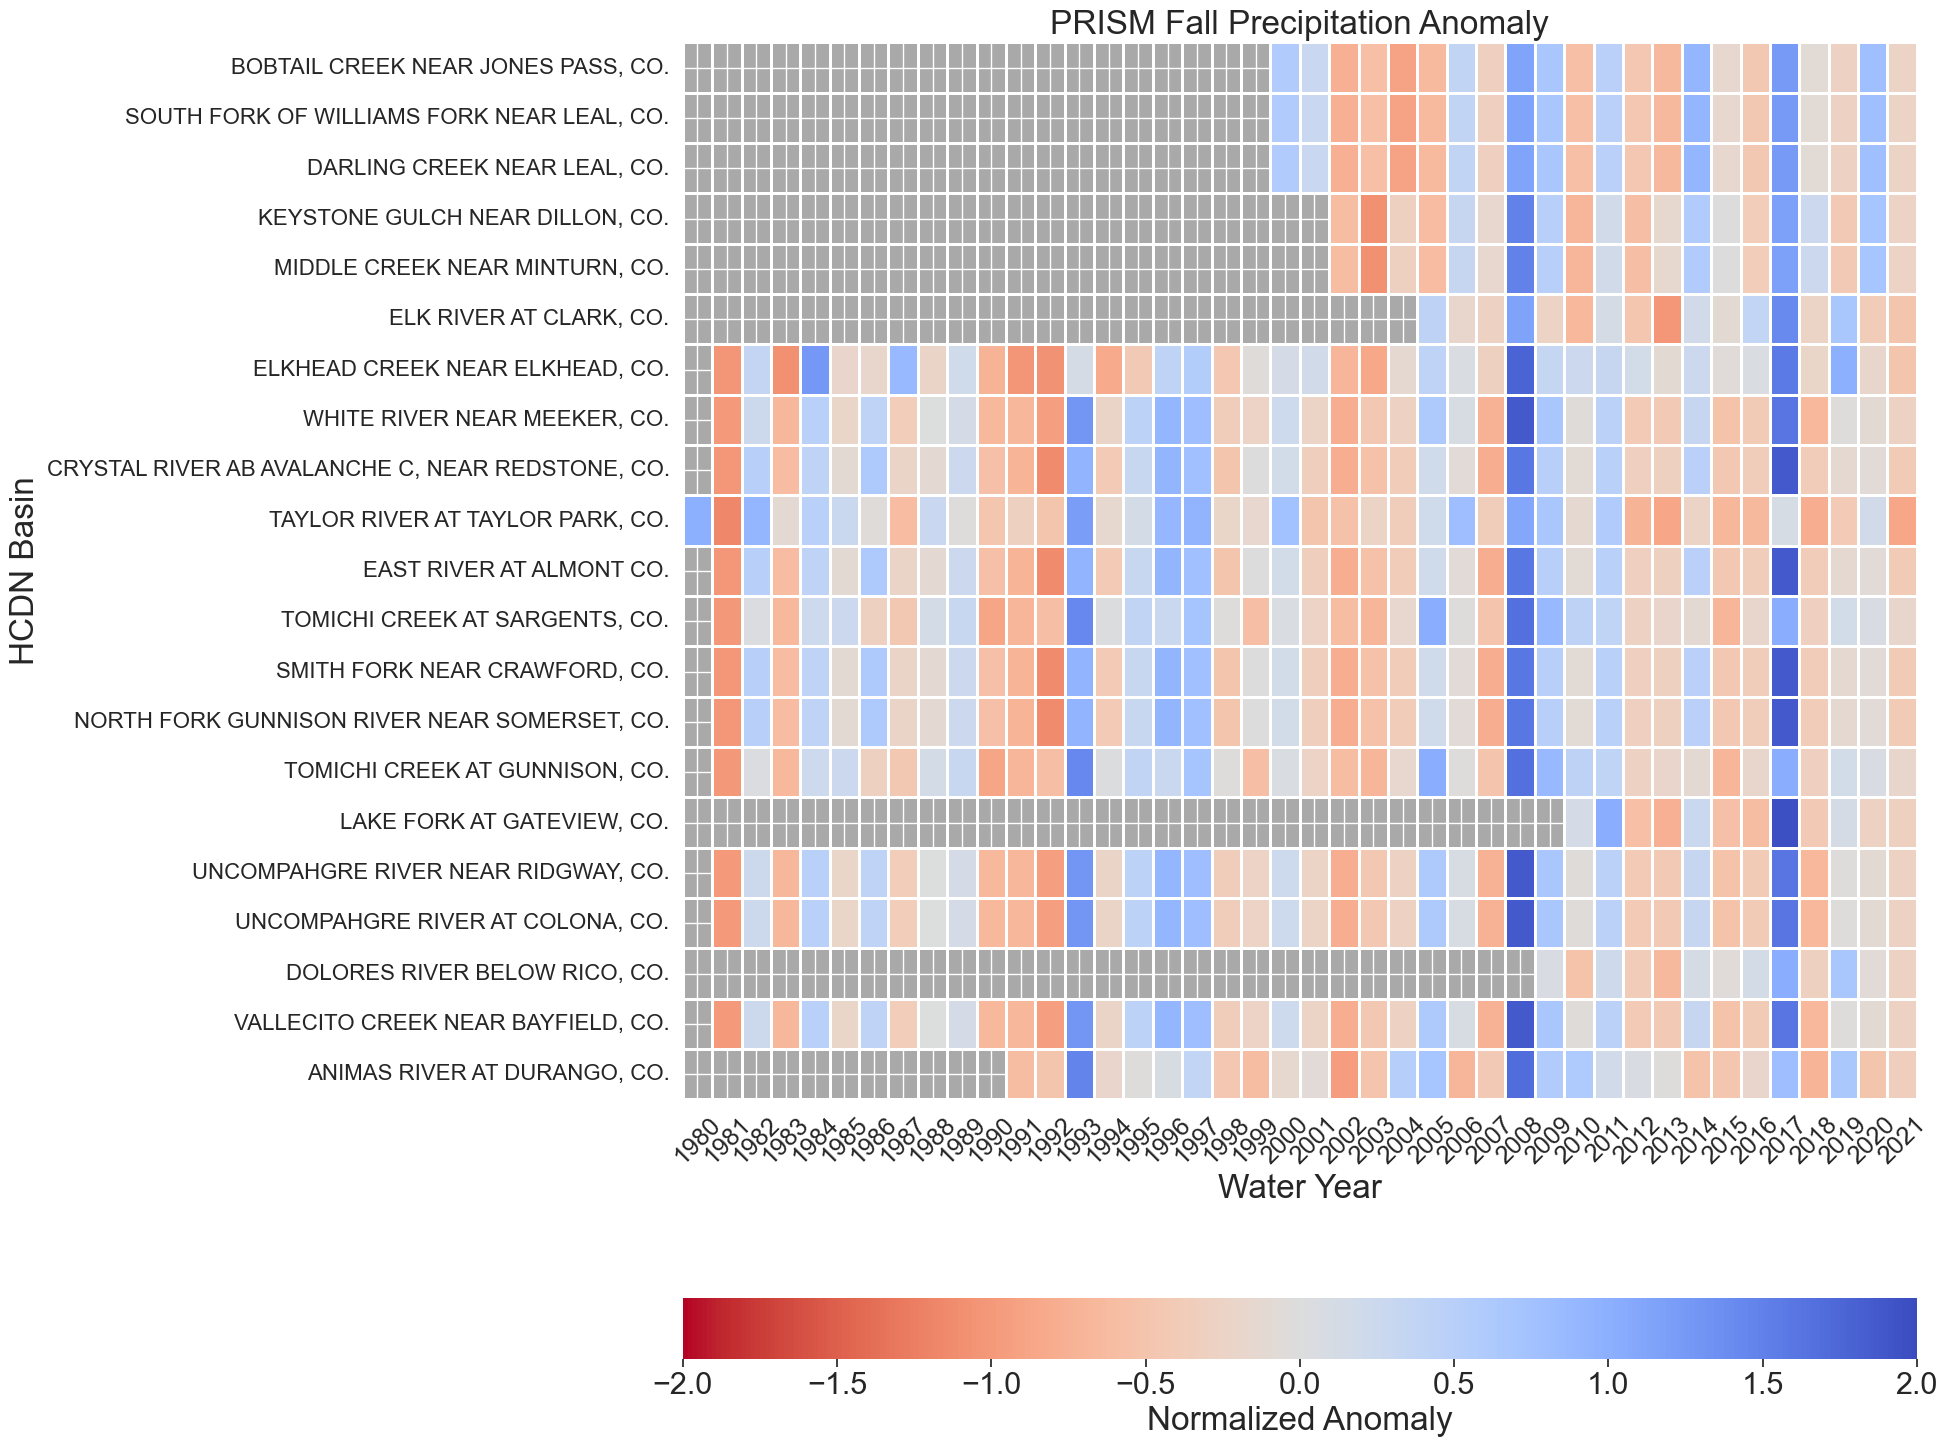

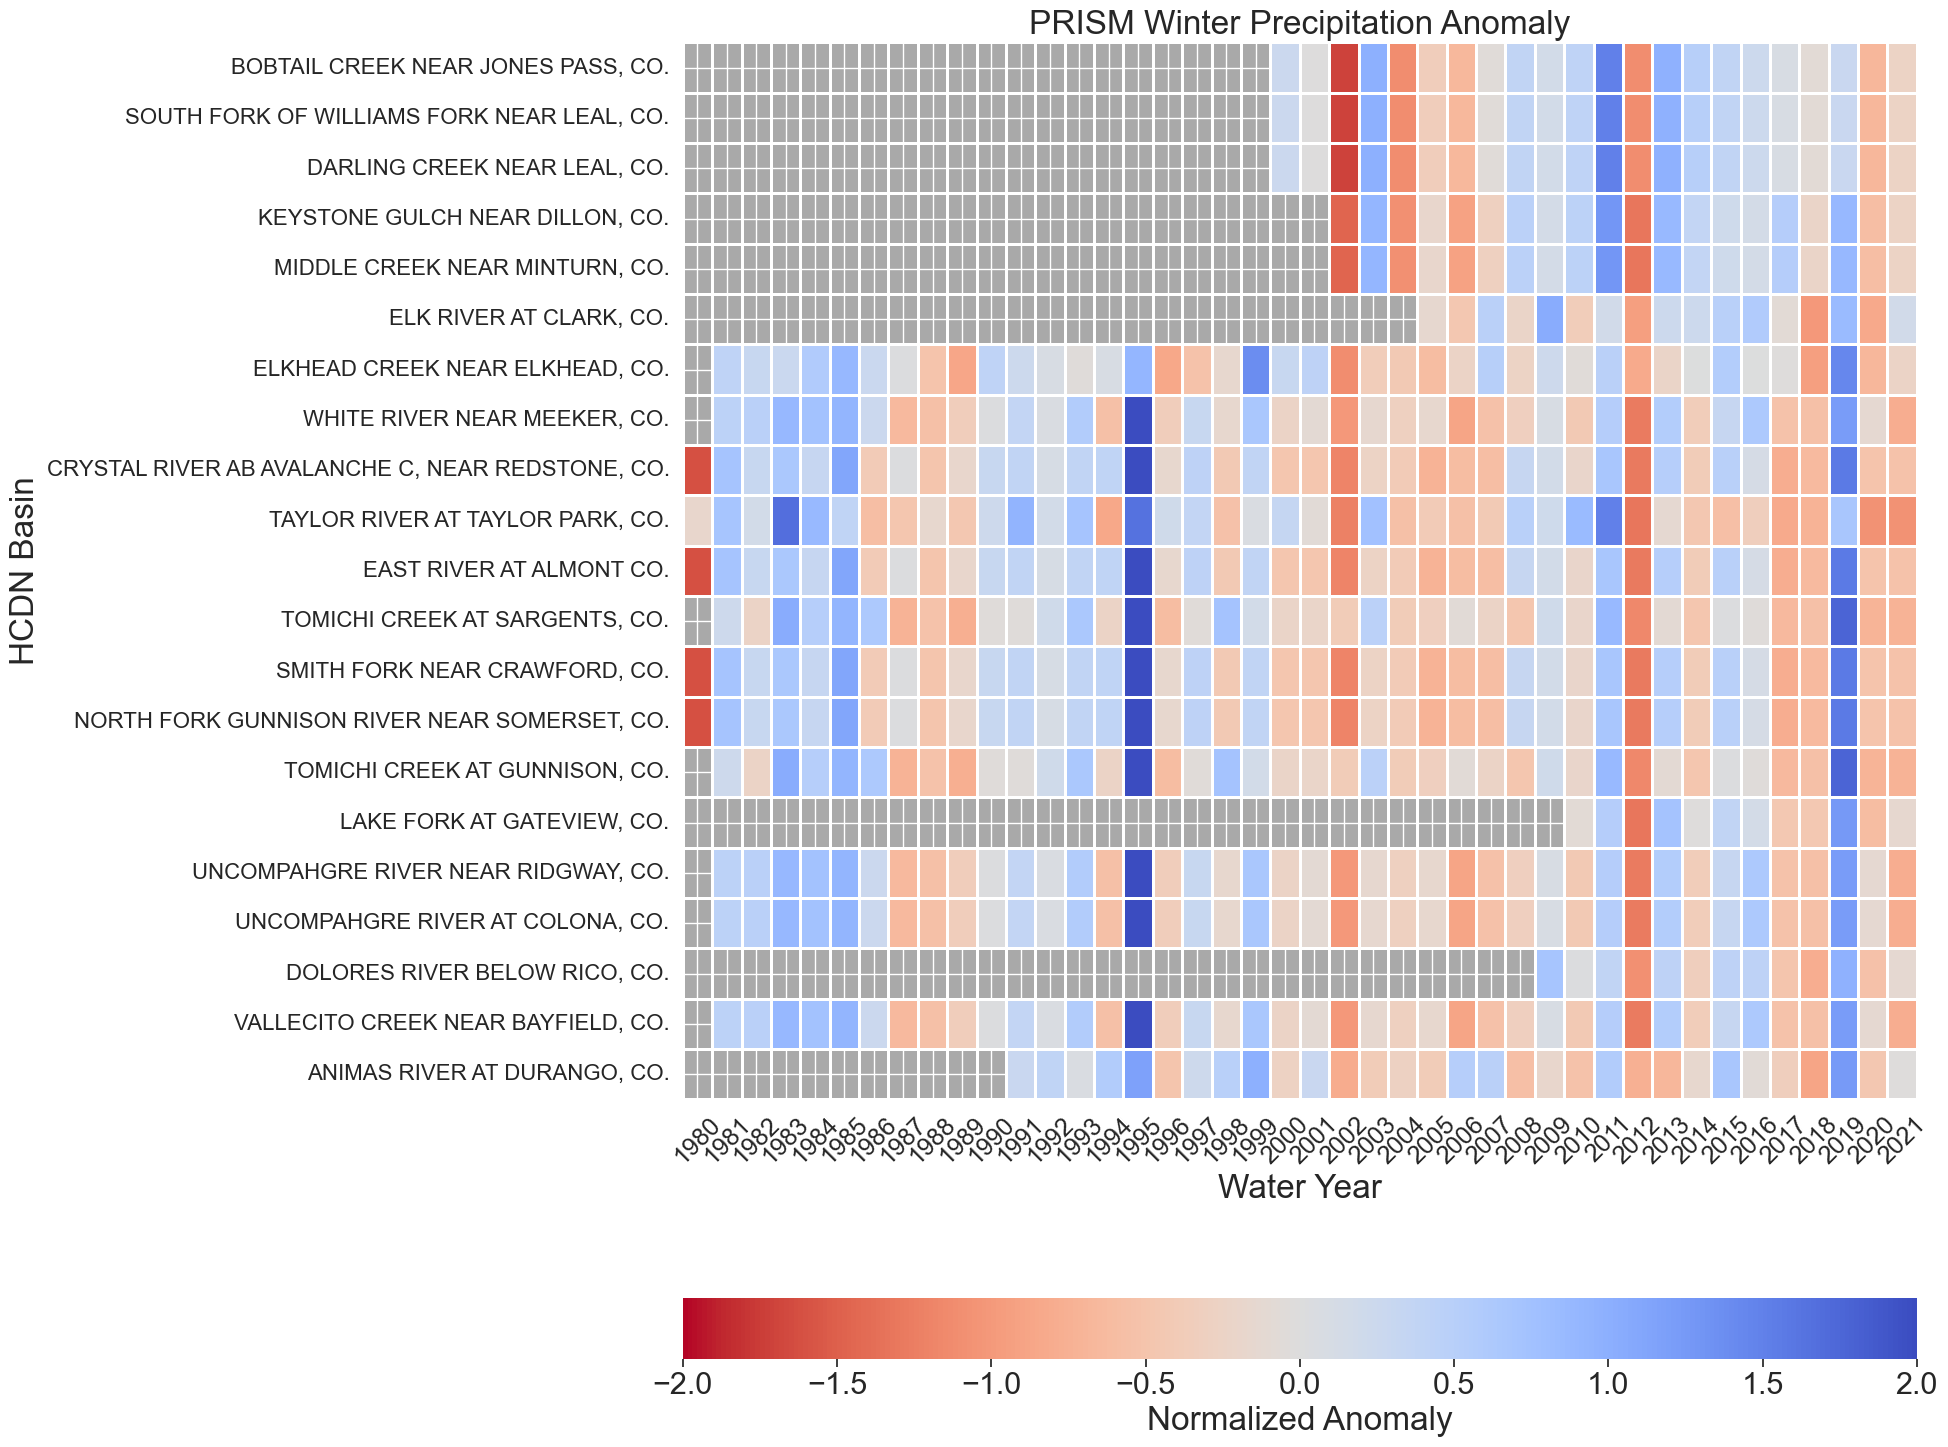

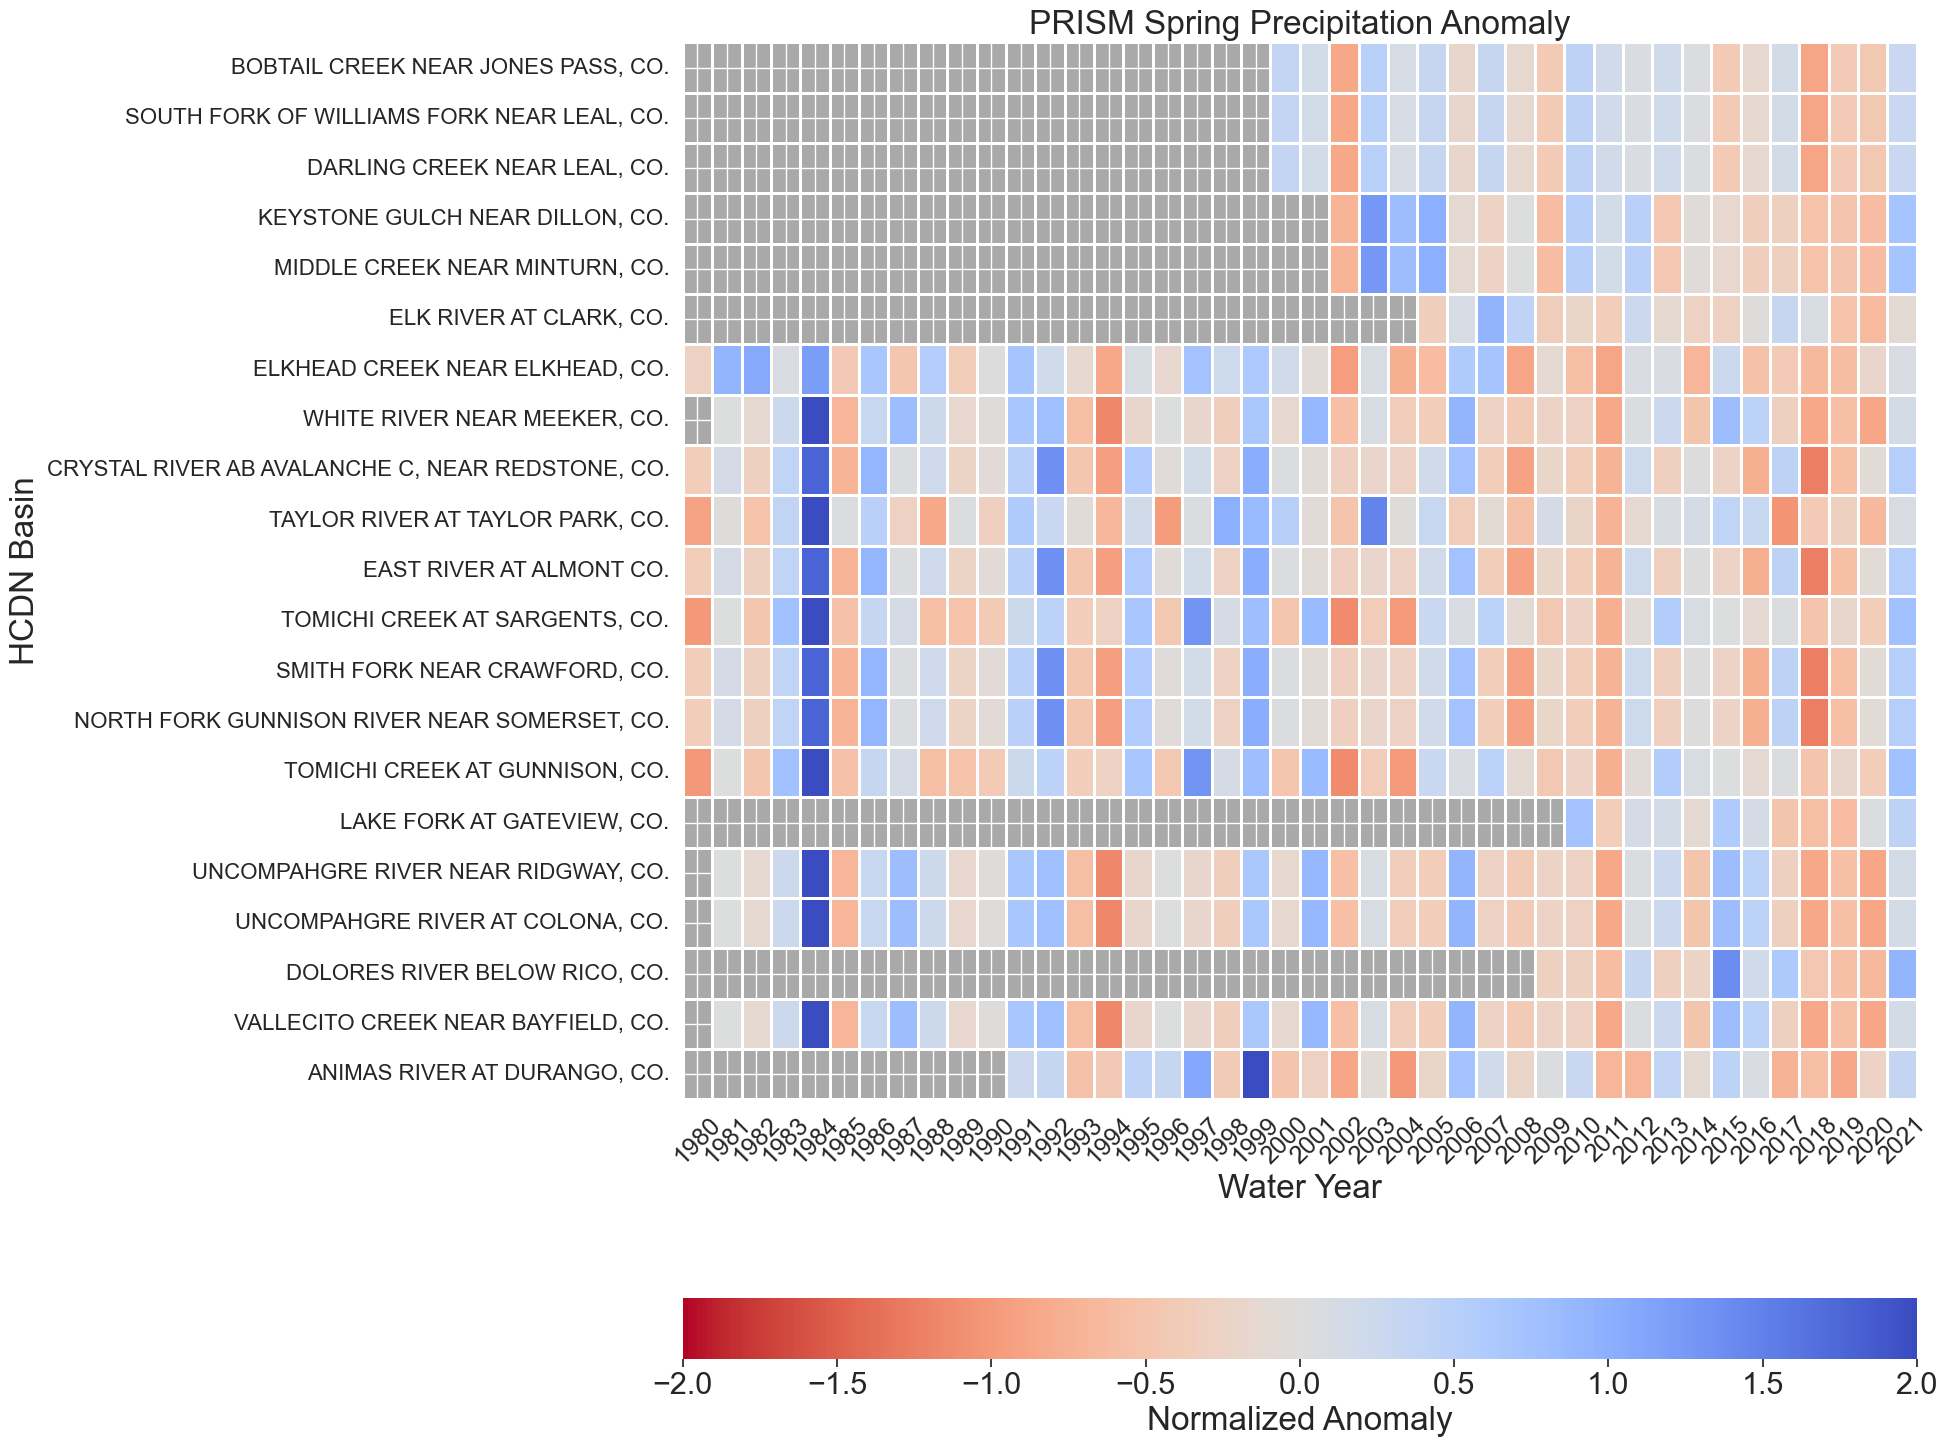

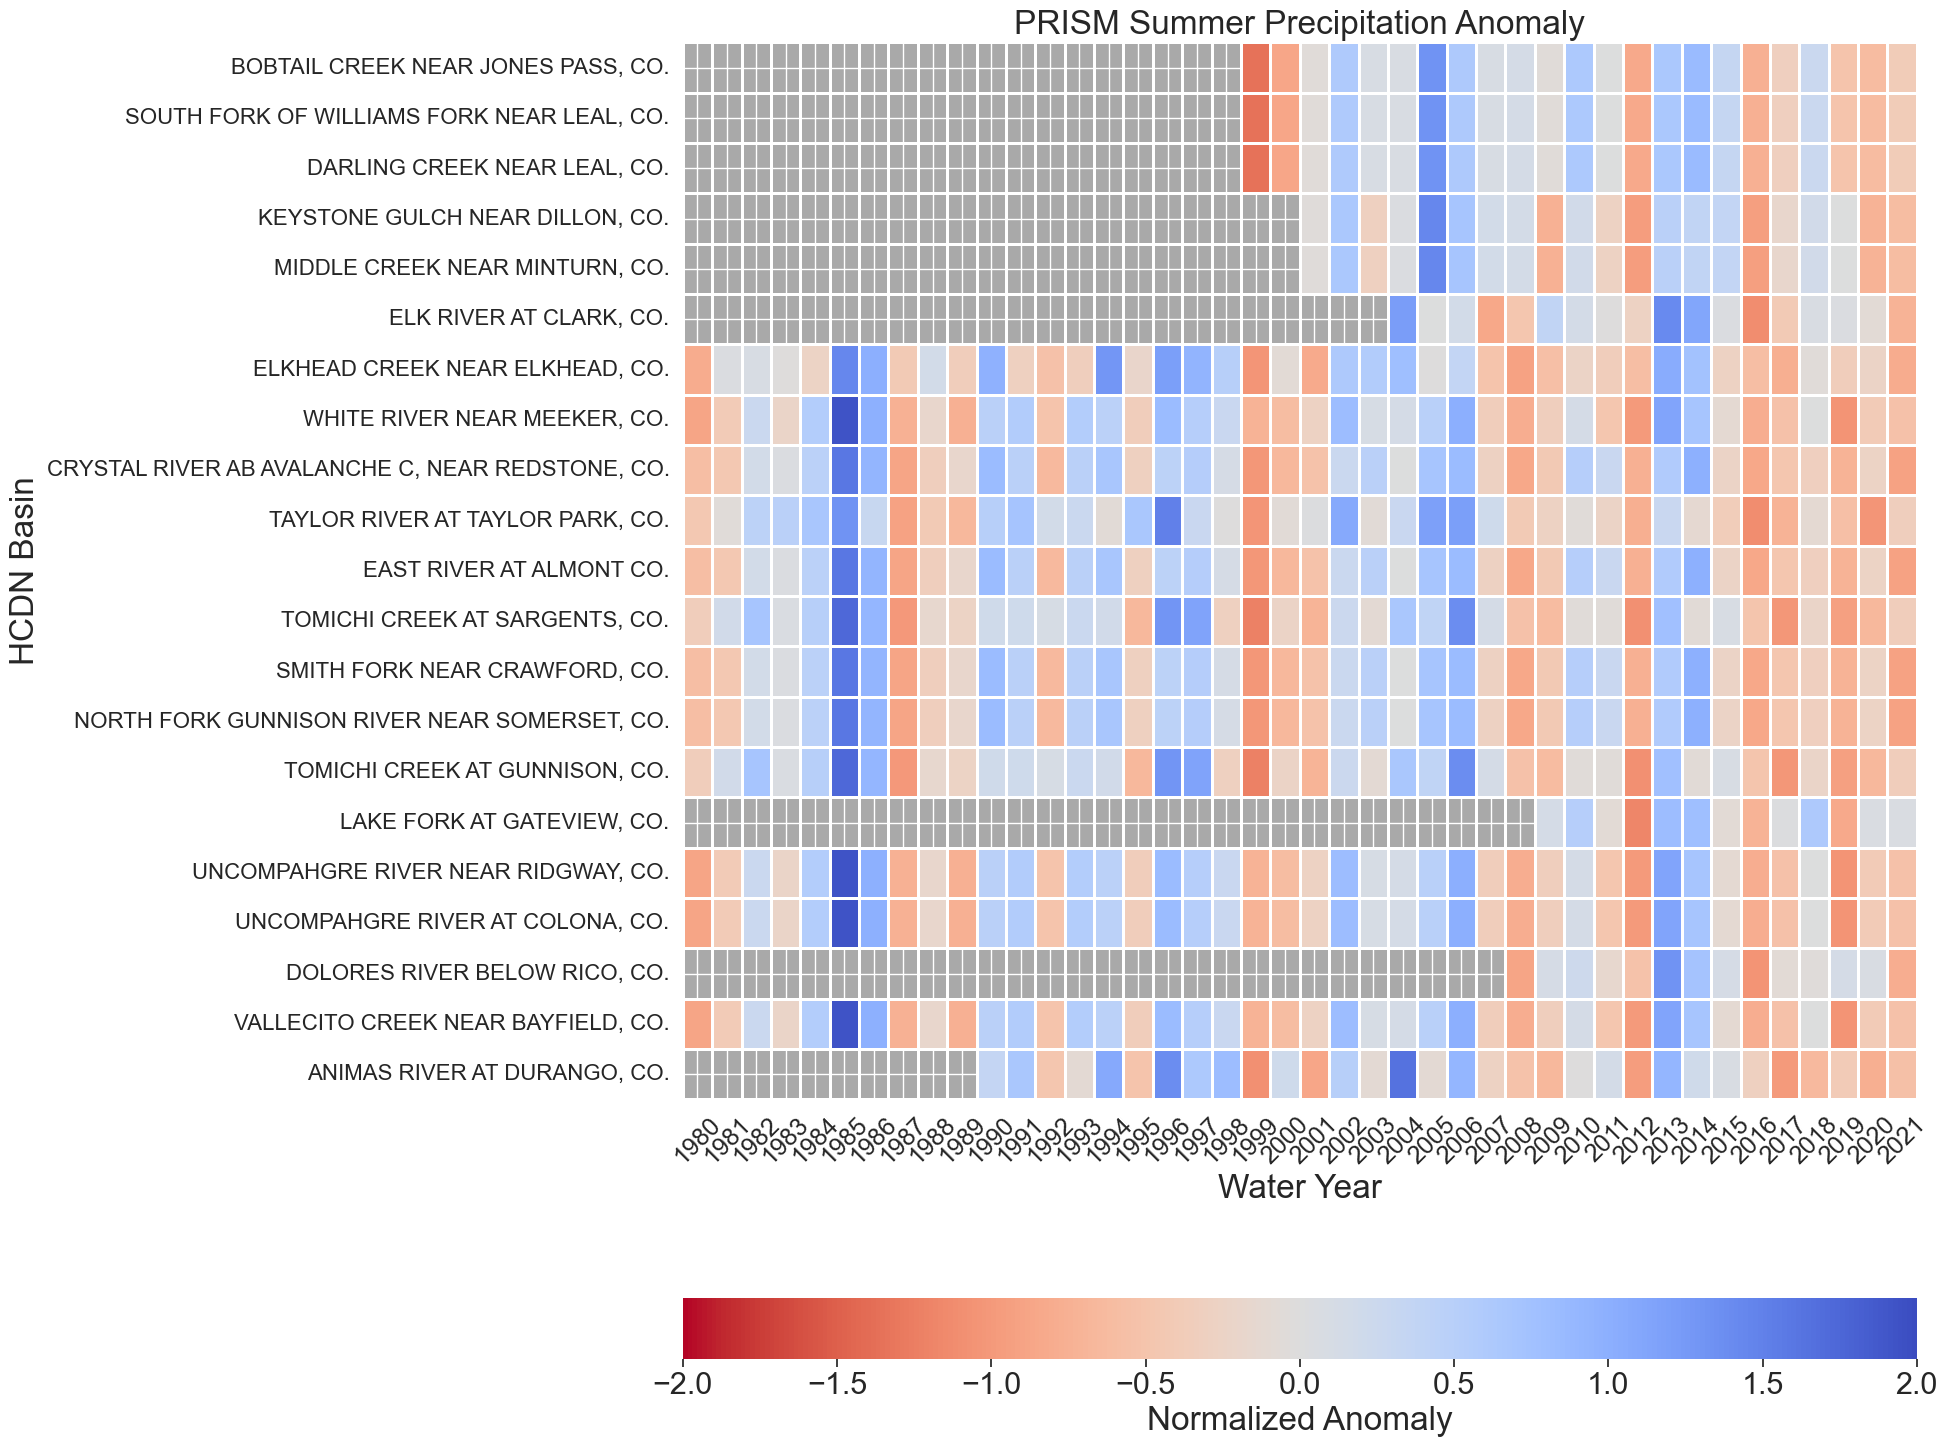

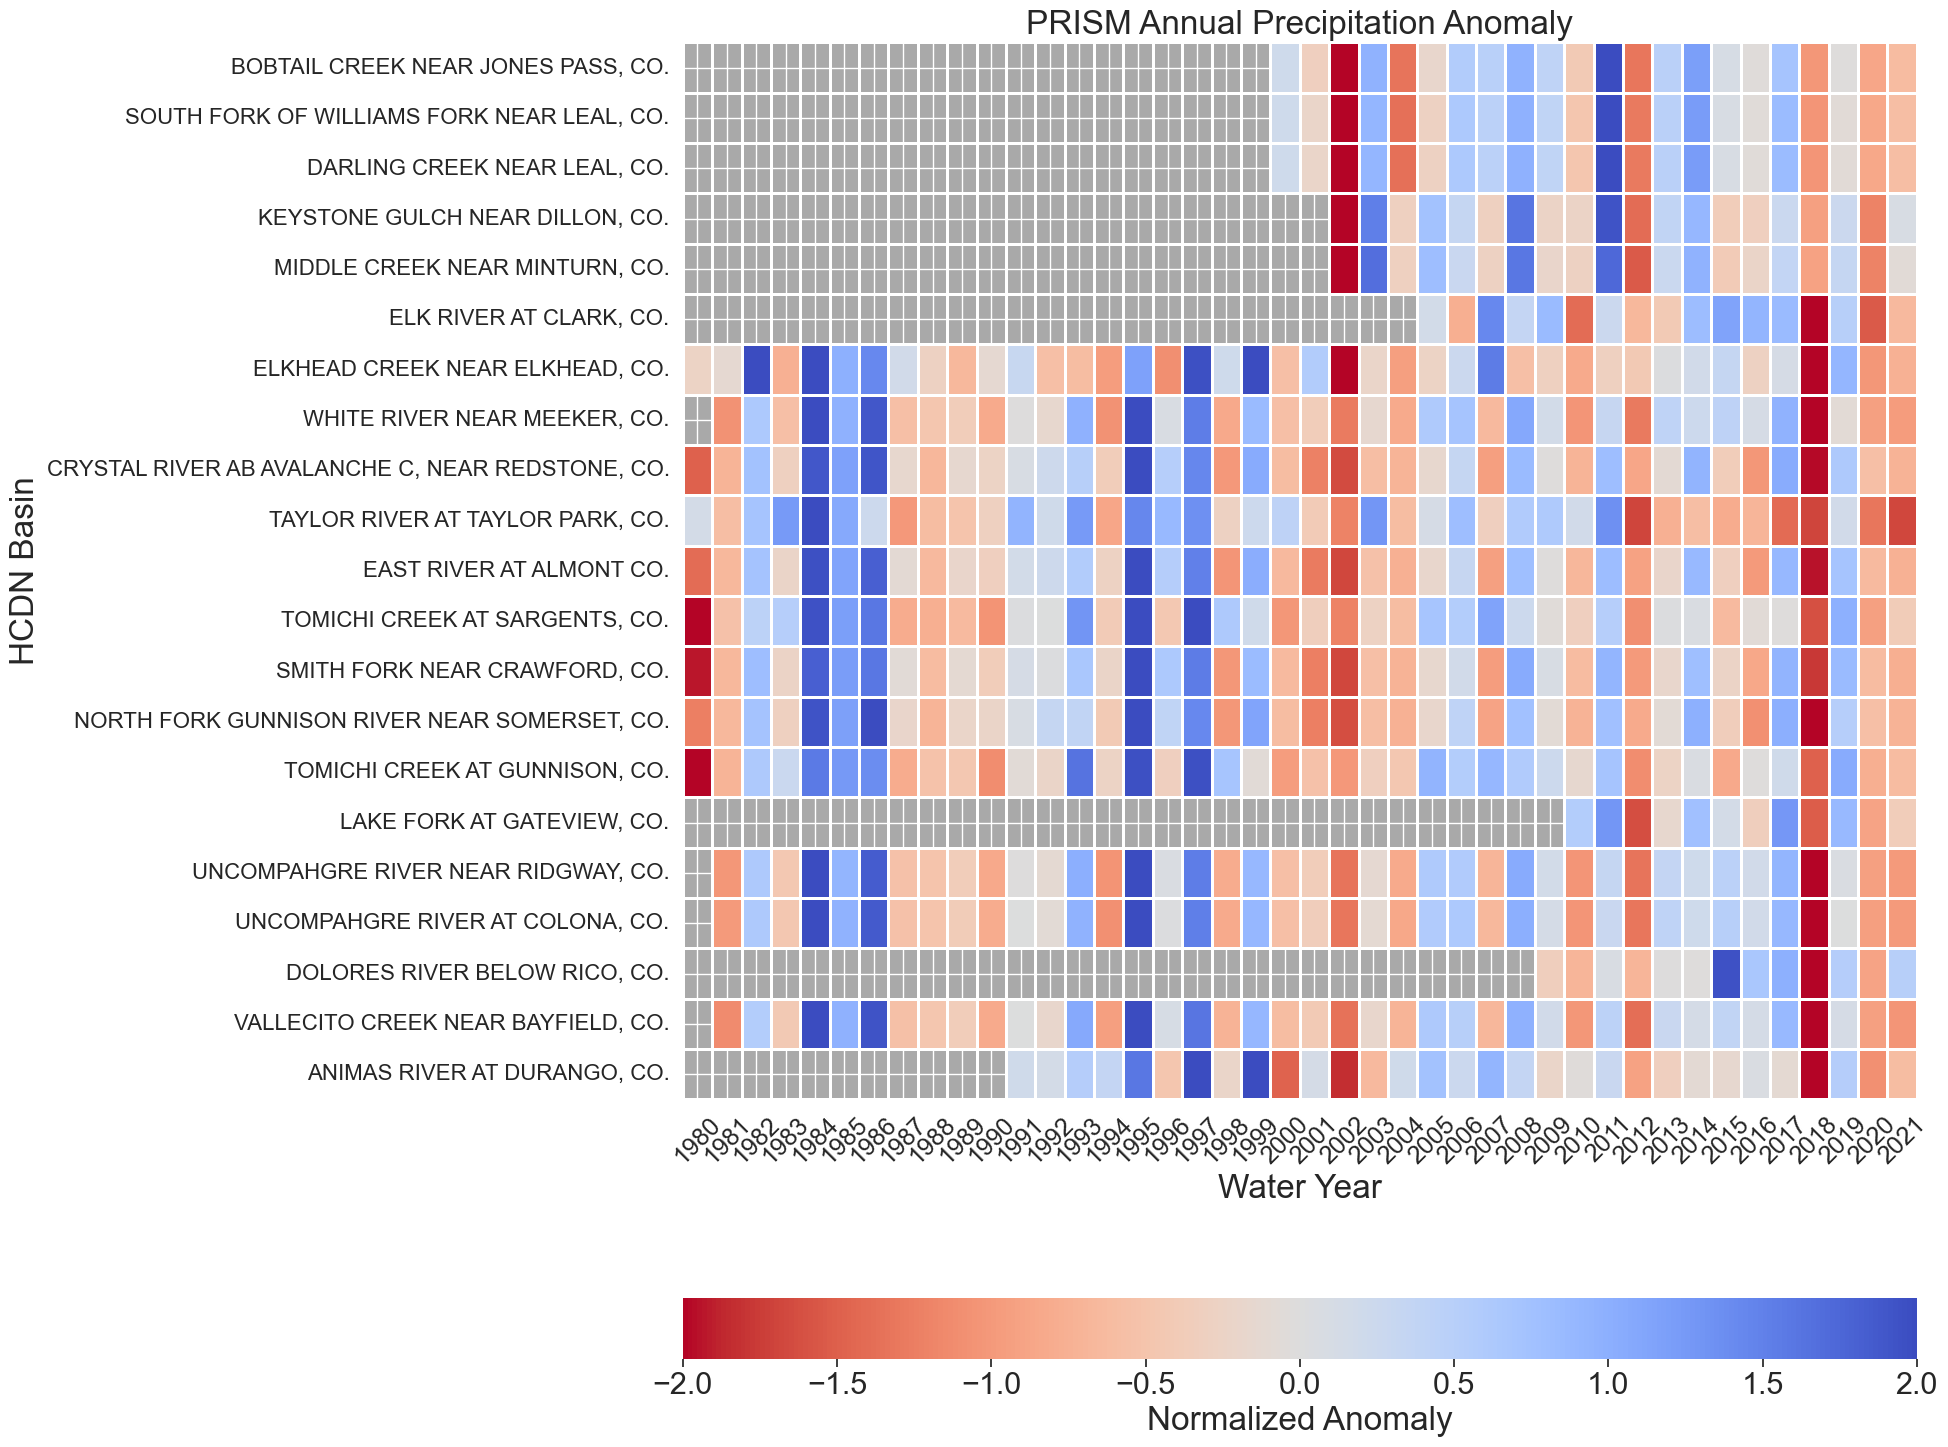

In [22]:
sns.set(font_scale=2, rc={'axes.facecolor':'darkgrey'})
labels = ['Fall','Winter','Spring','Summer','Annual']

for i,df in enumerate([hcdn_fall_precip, hcdn_winter_precip, hcdn_spring_precip, hcdn_summer_precip, norm_annual_mean_prism_df]):
    fig, ax=plt.subplots(nrows=1,figsize=(20,15), facecolor='w',tight_layout=True)
    df_transpose = df.loc[1980:2021][plotting_cols].T
    sns.heatmap(df_transpose, 
                cmap='coolwarm_r', 
                vmin=-2, 
                vmax=2,
                linewidths=2, 
                cbar_kws={'label':'Normalized Anomaly',
                        'orientation':'horizontal',
                        'fraction':.05},
                ax=ax)
    ax.set_yticklabels(df_transpose.index, rotation=0, ha='right', size=16);
    ax.set_xticklabels(df_transpose.columns, rotation=45, ha='center', size=18);
    ax.set_ylabel('HCDN Basin',size=24)
    ax.set_xlabel('Water Year', size=24)
    ax.set_title(f'PRISM {labels[i]} Precipitation Anomaly', size=24)
